In [324]:
from micrograd.engine import Value

* backward() finds the derivative using chain rule corresponding to each of the values it includes
* a larger gradient descent (.grad()) means that by changing a certain variable by a small amount the function will increase by the output of .grad()

In [413]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [329]:
def f(x):
    return 3*x**2 - 4*x + 5
f(3.0)

20.0

derivative - what sensitivity does the function has when we increase by a certain input x, with a very samll difference h

In [332]:
h = 0.000001
x = 2/3
print(f(x+h))
(f(x+h)-f(x))/h

3.6666666666696663


2.999378523327323e-06

This is slightly greater than the value at x = 3.0, which means that the sloop is positive. If it is negative that means the slop is negative and the function will go down there if the x is increased by a small amount.

In [335]:
a = 2.0
b = -3.0
c =10.0
d = a*b +c
print(d)

4.0


In [337]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c =10.0

d1 = a*b +c
c+=h
d2 = a*b +c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


if we increase a that would lead to a negative slope
if we increase b that would lead to a positive slope because then we are multiplying by a less negative number
if we increase c (maybe like an anlaogy for the bias) it would lead to 

In [506]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._backward = lambda: None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # makes it so that it can add non-Value int objects 
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other),'*')

        def _backward():
            # have to do += instead of just = so that
            # it works in the cases where
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
    
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad = 1.0
        build_topo(self)
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
a + b # this calls the __add__ method automatically and uses the __repr__ t\o print it out below
d = e + c; d.label = 'd' # equivalent to a.__mul__(b).__add__(c)
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [494]:
d._prev # takes in the variables that were used for the operation (last operation was addition, so its -6 and 10)

{Value(data=-6.0), Value(data=10.0)}

In [346]:
d._op # saves what the operation to get to this current value was

'+'

In [348]:
# following along with the video

import graphviz
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
                     
        
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
      

  return dot


In [201]:
# CODE I WROTE INDEPENDENTLY which worked for the simple scenario??
def find_grad(root):
    def build_grad(v, curChain):
        v.grad = curChain
        for child in v._prev:
            if v._op == '*':
                if(child.data == 0):
                    build_grad(child, 0)
                build_grad(child, v.data/child.data*v.grad)
            if v._op == '+':
                build_grad(child, v.grad)  
    build_grad(root, 1)


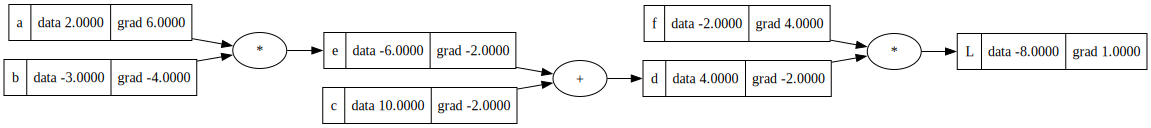

In [154]:
find_grad(L)
draw_dot(L)

L = d * f

DL/dd = f 
treat f as a constant and d as the variable ( just like dz/dy or dz/dx, you think of one as a constant)


In [81]:
L = d * f

def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd' # equivalent to a.__mul__(b).__add__(c)
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L' # derivative L with repsect to itself would be proportional  so it's gradient would just be 1
    L1 = L

    # we add to the a value over here for L2
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd' # equivalent to a.__mul__(b).__add__(c)
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L2 = L

    # so this is giving the derivative with respect to a in this case
    print((L2-L1)/h)

how do we no dL/dC we can simply multiply dC/dD and dD/dL and when we do that we can then get the dC/dL!! - chain rule from calculus
and this is most important part of how backpropogoation works with so many weights and biases from all the preceding neuron layers

WANT:
dL/ dc

KNOW:
dL/ dd
dd / dc

dL/dc = dL/ dd * dd / dc


local derivative - a derivative that is in the middle of the graph doesn't know the derivative of the final node/output with respect to the middle node

usually has a squishification function on the activation (such as sigmoid like in 3B1B) - can be modeled using the numpy tanh function

In [366]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1-w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [368]:
o.backward()

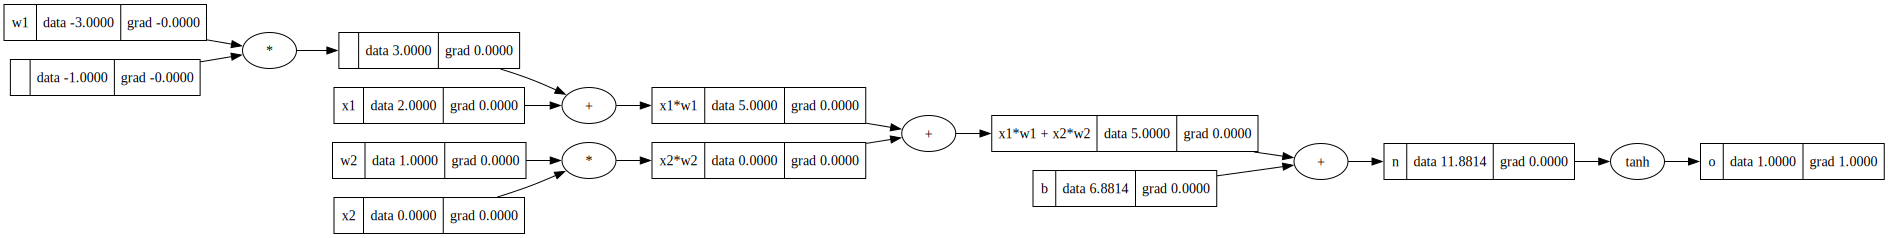

In [370]:
draw_dot(o)

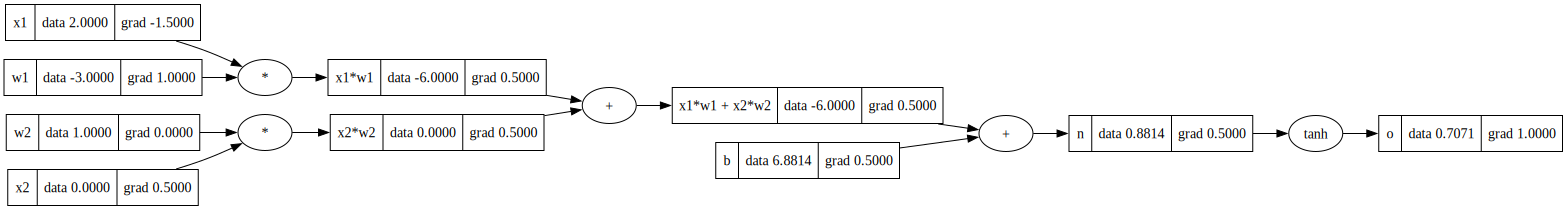

In [261]:
o.grad = 1.0 # have to set the gradient to 1 in the root/base case so that it isn't set to 0.0 automatically
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

have to make sure while doing this to go in the backwards order of the dependencies so ._backward is only called on nodes which have already had their gradients calculated

- we do this with topological ordering

In [273]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
for node in reversed(topo):
    node._backward()

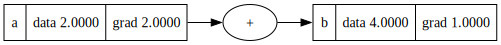

In [318]:
a = Value(2.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

# manually finding the gradients
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [402]:
import torch

# casting to double to mkae it float64 instead of default float amount
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1+x2*w2+b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())


0.7071066904050358
x2 0.5000001283844369


o.item() and o.data.item() will both give the same output of the data as a float
pytorch is very efficient as it can allow us to do several computations at onces using the tensors

will now be creating a multi-layer perceptron below

In [417]:
import random

In [602]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # this zip connects the associating pair of weights and x's
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        return act.tanh()

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # equivalent to below code
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [604]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.976999446386927)

In [606]:
n.parameters()

[Value(data=-0.738671340351089),
 Value(data=0.9830994763347773),
 Value(data=-0.06676505882317807),
 Value(data=0.3383437285301869),
 Value(data=-0.18989836943105032),
 Value(data=-0.9494259134862999),
 Value(data=-0.07330503024031532),
 Value(data=-0.697871966572783),
 Value(data=0.7319385557522124),
 Value(data=-0.7086333540923004),
 Value(data=-0.5618497970522556),
 Value(data=-0.43583580762100116),
 Value(data=-0.5539437948872956),
 Value(data=0.27291805827959115),
 Value(data=-0.32349350401212695),
 Value(data=-0.4685583377392475),
 Value(data=0.33710979956293863),
 Value(data=0.52148912676797),
 Value(data=-0.8434037686717892),
 Value(data=-0.754185086297114),
 Value(data=-0.15214357956549662),
 Value(data=-0.8312804692003437),
 Value(data=-0.39220821483794666),
 Value(data=0.5731268485513001),
 Value(data=0.6569621847695426),
 Value(data=-0.6685359961821322),
 Value(data=-0.6150662631314641),
 Value(data=0.8057655058050557),
 Value(data=-0.2580441153363029),
 Value(data=-0.6582

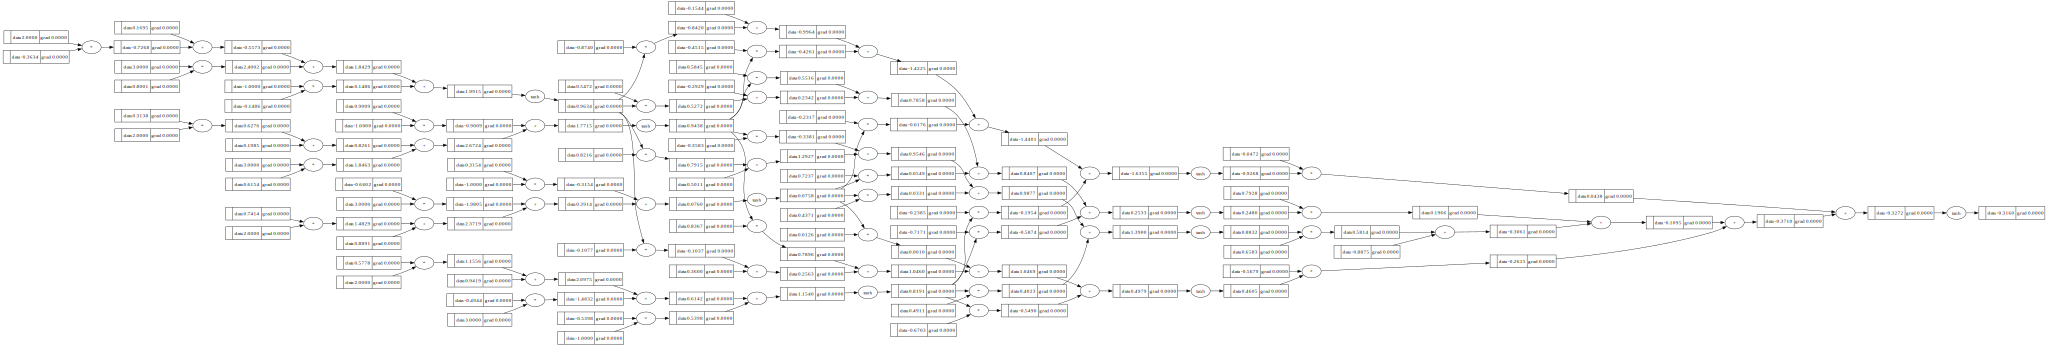

In [443]:
draw_dot(n(x))

* How can we tune the weights of this multilayer perceptron to given a a dataset of input sand desired outpus (xs and ys)

* Can calculate the mean-squared error by subtracting the difference between the desired y and the actually predicted y and then squaring it or taking absolute value is also fine for loss but just want to make sure it is positive
    * the loss is only 0 when the prediction and desired target are the same



In [706]:
xs = [[2.0, 3.0, -1.0],[3.0, -1.0,0.5], [0.5, 1.0, 1.0], [1.0, 1.0,-1.0]]
ys = [1.0, -1.0,-1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9587792317076427),
 Value(data=-0.8640346554314635),
 Value(data=0.9266977803840137),
 Value(data=0.799199706923089)]

In [708]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
[abs((yout - ygt).data) for ygt, yout in zip(ys, ypred)]
print(list(zip(ys, ypred)))

[(1.0, Value(data=0.9587792317076427)), (-1.0, Value(data=-0.8640346554314635)), (-1.0, Value(data=0.9266977803840137)), (1.0, Value(data=0.799199706923089))]


In [710]:
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))
loss

Value(data=3.772670821298712)

In [712]:
loss.backward()

In [714]:
for p in n.parameters():
    # multiply by negative because gradient gives in which direction it would increase the most
    # so - gives the direction of the opposite where it would decrease the most
    p.data += -0.01 * p.grad

iteratively does forward pass to predict and then calculating the new loss and then doing backward pass/finding new gradients and then doing gradient descent based on these new outputs/parameters

how much we scale the grad is the learning rate - but make sure it is not too high because that would cause it to overshoot and not 

In [723]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))

    #backward pass
    # have to make sure to 0-grad or make all the gradiensts 0 everytime we do backward -> this is what zero grad does in pytorch
    # if you don't it is equivalent to like having a bigger and bigger step size but it is still going in the right "direction"? positive/negative
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 1.62430637496733e-10
1 1.624306341941996e-10
2 1.6243063089167952e-10
3 1.6243062758914616e-10
4 1.6243062428662615e-10
5 1.6243062098409287e-10
6 1.6243061768155964e-10
7 1.6243061437903975e-10
8 1.6243061107650658e-10
9 1.6243060777114354e-10
10 1.6243060446862373e-10
11 1.6243060116609066e-10
12 1.624305978635709e-10
13 1.624305945610379e-10
14 1.6243059125850494e-10
15 1.6243058795598529e-10
16 1.624305846534524e-10
17 1.624305813509195e-10
18 1.6243057804557012e-10
19 1.624305747430373e-10
